In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from folium.plugins import Draw
from folium.plugins import MarkerCluster
import numpy as np

In [2]:
# Employee_Addresses
pd_ea= pd.read_csv('Employee_Addresses.csv')
pd_pbs= pd.read_csv('Potentail_Bust_Stops.csv')

In [3]:
print(pd_ea.keys())
print(pd_ea.shape)

Index(['address', 'employee_id'], dtype='object')
(2191, 2)


In [4]:
print(pd_pbs.keys())
print(pd_pbs.shape)

Index(['Street_One', 'Street_Two'], dtype='object')
(119, 2)


In [5]:
def findCoordinatesEmp(address):
    address=address.replace(",", "").replace(" ","+")
    result = requests.get('https://geocoder.api.here.com/6.2/geocode.json?app_id=5eGneaHRrTWRF5aF3i7c&app_code=_OFlUS3V71hl4RmO6vr15g&searchtext="%s"'%address)
    return [result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']]

In [7]:
"""
coorEmp_Lat=[]
coorEmp_Lon=[]
for index,row in pd_ea.iterrows():
    result=findCoordinatesEmp(row['address'])
    coorEmp_Lat.append(result[0])
    coorEmp_Lon.append(result[1])
pd_coordinatesEmp=pd.DataFrame({"Lat":coorEmp_Lat, "Lon":coorEmp_Lon })
pd_coordinatesEmp.to_csv("coordinates_emp.csv",index=False)
"""

'\ncoorEmp_Lat=[]\ncoorEmp_Lon=[]\nfor index,row in pd_ea.iterrows():\n    result=findCoordinatesEmp(row[\'address\'])\n    coorEmp_Lat.append(result[0])\n    coorEmp_Lon.append(result[1])\npd_coordinatesEmp=pd.DataFrame({"Lat":coorEmp_Lat, "Lon":coorEmp_Lon })\npd_coordinatesEmp.to_csv("coordinates_emp.csv",index=False)\n'

In [8]:
pd_coordinatesEmp= pd.read_csv('coordinates_emp.csv')

In [9]:
def findCoordinatesPBS(street2):
    street2_split=street2.split(" ")
    if len(street2_split) > 1:
        street2=street2_split[0]
        for i in range(1,len(street2_split)):
            street2=street2+"%20"+street2_split[i]
    else:
        street2=street2_split[0]
    result = requests.get('https://geocoder.api.here.com/6.2/geocode.json?city=San%20Francisco&street=%20MISSION%20%40%20{}&app_id=5eGneaHRrTWRF5aF3i7c&app_code=_OFlUS3V71hl4RmO6vr15g&gen=9'.format(street2))
    try:
        return [result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']]
    except:
        street2_split=street2.replace(" ST","").split(" ")
        if len(street2_split) > 1:
            street2=street2_split[0]
            for i in range(1,len(street2_split)):
                street2=street2+"%20"+street2_split[i]
        else:
            street2=street2_split[0]
        result = requests.get('https://geocoder.api.here.com/6.2/geocode.json?city=San%20Francisco&street=%20MISSION%20%40%20{}&app_id=5eGneaHRrTWRF5aF3i7c&app_code=_OFlUS3V71hl4RmO6vr15g&gen=9'.format(street2))
        try:
            return [result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude'],result.json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']]
        except:
            return False

In [116]:
""" 
Missing value ANGELOS ALY. The real value is ANGELO'S ALY, therefore I can't parse it in parameter.


coorBus_Lat=[]
coorBus_Lon=[]
streetTwo=[]
for index,row in pd_pbs.iterrows():
    result=findCoordinatesPBS(row['Street_Two'])
    if result:
        coorBus_Lat.append(result[0])
        coorBus_Lon.append(result[1])
        streetTwo.append(row['Street_Two'])
pd_coorbus=pd.DataFrame({"Lat":coorBus_Lat, "Lon":coorBus_Lon ,"name":streetTwo})
pd_coorbus.to_csv("coordinates_bus.csv",index=False)
"""

In [12]:
pd_coorbus= pd.read_csv('coordinates_bus.csv')

In [169]:
lats=np.array(pd_coordinatesEmp['Lat'])
lons=np.array(pd_coordinatesEmp['Lon'])

popups = ['{}'.format(row['address']) for index,row in pd_ea.iterrows()]

latsBus=np.array(pd_coorbus['Lat'])
lonsBus=np.array(pd_coorbus['Lon'])

popupsBus = ['{}'.format(row['Street_Two']) for index,row in pd_pbs.iterrows() if row['Street_Two'] != 'ANGELOS ALY']

icon_create_function = """\
function(cluster) {
    return L.divIcon({
    html: '<b>' + cluster.getChildCount() + '</b>',
    className: 'marker-cluster marker-cluster-large',
    iconSize: new L.Point(20, 20)
    });
}"""
"""
m = folium.Map(
    location=[np.mean(lats), np.mean(lons)],
    zoom_start=12.5
)
 
for k in range(len(lats)):
    folium.Marker([lats[k],lons[k]], popup=popups[k]).add_to(m)

for index,row in pdPTB[:10].iterrows():
    folium.Marker([latsBus[int(row["pos"])],lonsBus[int(row["pos"])]], popup=popupsBus[int(row["pos"])], icon=folium.Icon(color='red')).add_to(m)
    

marker_cluster = MarkerCluster(
    name='Insight',
    overlay=True,
    control=False,
    icon_create_function=None
)

for k in range(len(lats)):
    location = lats[k], lons[k]
    marker = folium.Marker(location=location)
    popup =popups[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)
    
for k in range (len(latsBus)):
    locationBus = latsBus[k], lonsBus[k]
    marker = folium.Marker(location=locationBus)
    popup =popupsBus[k]
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(m)

folium.LayerControl().add_to(m)

m.save(os.path.join('Result.html'))

m
"""

'\nm = folium.Map(\n    location=[np.mean(lats), np.mean(lons)],\n    zoom_start=12.5\n)\n \nfor k in range(len(lats)):\n    folium.Marker([lats[k],lons[k]], popup=popups[k]).add_to(m)\n\nfor index,row in pdPTB[:10].iterrows():\n    folium.Marker([latsBus[int(row["pos"])],lonsBus[int(row["pos"])]], popup=popupsBus[int(row["pos"])], icon=folium.Icon(color=\'red\')).add_to(m)\n    \n\nmarker_cluster = MarkerCluster(\n    name=\'Insight\',\n    overlay=True,\n    control=False,\n    icon_create_function=None\n)\n\nfor k in range(len(lats)):\n    location = lats[k], lons[k]\n    marker = folium.Marker(location=location)\n    popup =popups[k]\n    folium.Popup(popup).add_to(marker)\n    marker_cluster.add_child(marker)\n    \nfor k in range (len(latsBus)):\n    locationBus = latsBus[k], lonsBus[k]\n    marker = folium.Marker(location=locationBus)\n    popup =popupsBus[k]\n    folium.Popup(popup).add_to(marker)\n    marker_cluster.add_child(marker)\n\nmarker_cluster.add_to(m)\n\nfolium.Layer

In [16]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True)
reg.fit(lons.reshape(-1,1),lats.reshape(-1,1))
f = lambda x: reg.intercept_+ reg.coef_*x

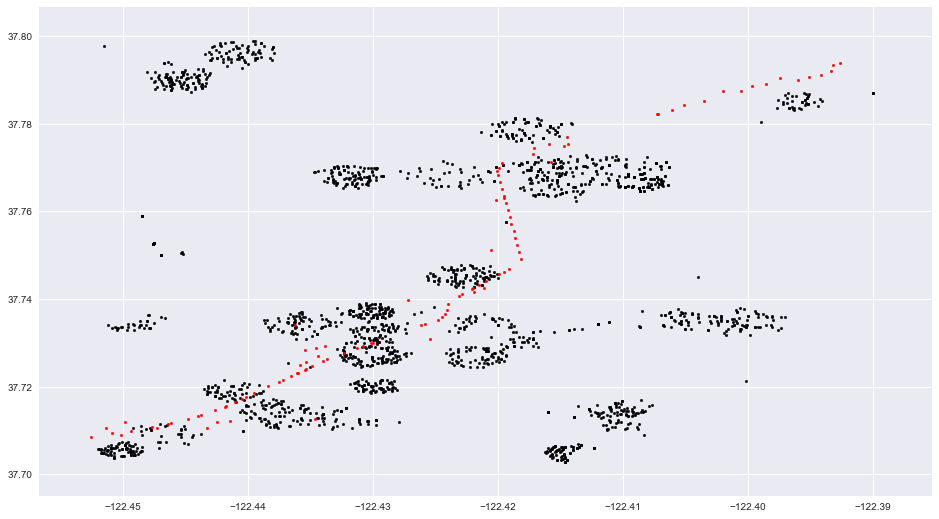

In [154]:
plt.scatter(lons,lats,c='black', s=7)
plt.scatter(lonsBus,latsBus, c='red', s=7)
plt.rcParams['figure.figsize'] = (16, 9)

In [65]:
from sklearn.cluster import KMeans
pointSet=np.array(list(zip(np.concatenate((lats,latsBus),axis=0), np.concatenate((lons,lonsBus),axis=0))))
pointSet=np.array(list(zip(lats,lons)))
# Number of clusters
kmeans = KMeans(n_clusters=14)
# Fitting the input data
kmeans = kmeans.fit(pointSet)
# Getting the cluster labels
labels = kmeans.predict(pointSet)
# Centroid values
centroids = kmeans.cluster_centers_

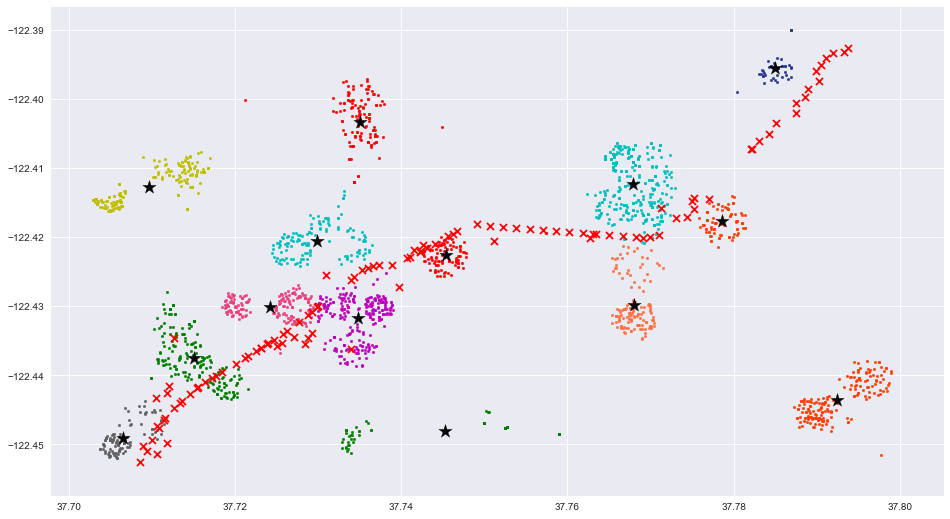

In [164]:
colors = ['#ff3d00', 'g', 'r', 'c', 'm', 'y', '#ff7043', '#616161','#ec407a','#283593']
fig, ax = plt.subplots()
for k in range(len(centroids)):
    points = np.array([pointSet[j] for j in np.array([i for i, x in enumerate(kmeans.labels_) if x == k])])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[k%10])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='#050505')
#ax.scatter(resultBus[:,0],resultBus[:,1], marker="d"	 , s=200, c='r')
ax.scatter(latsBus,lonsBus, marker="x"	 , s=50, c='r')

In [140]:
resultBus

[[37.74408, -122.42092],
 [37.70894, -122.45019],
 [37.77702, -122.41449],
 [37.71724, -122.44043],
 [37.72624, -122.43364],
 [37.73397, -122.43623],
 [37.77122, -122.41571],
 [37.78987, -122.39595],
 [37.73092, -122.42544],
 [37.76907, -122.42004]]

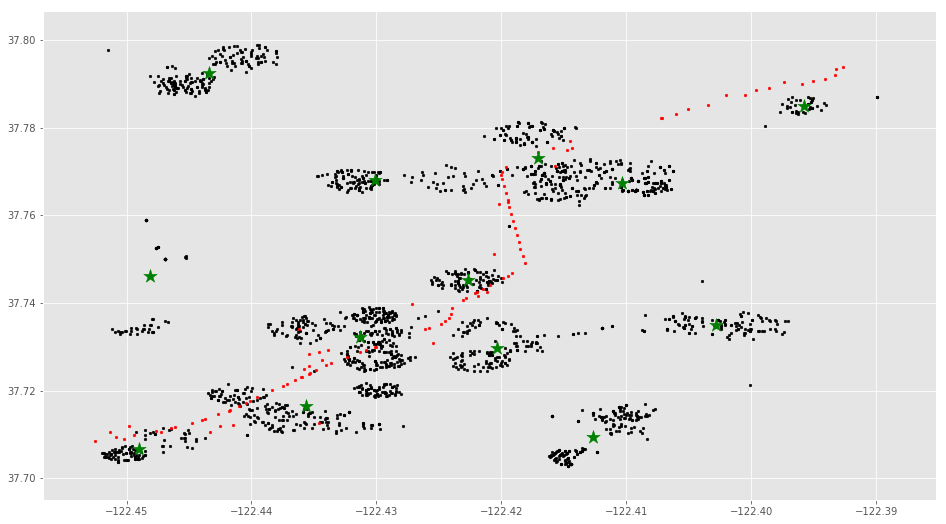

In [51]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
plt.scatter(lons,lats,c='black', s=7)
plt.scatter(lonsBus,latsBus, c='red', s=7)
plt.scatter(centroids[:,1],centroids[:,0], marker='*', s=200, c='g')

In [71]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [79]:
dist(np.array([2,3]),np.array([3,4]),0)

1.4142135623730951

In [103]:
npBus=np.array(pd_coorbus)
minCentroids=[]
for i in range(len(centroids)):
    min=0
    value=dist(npBus[0],np.array(centroids[i]),0)
    for j in range(len(npBus)):
        if value > (dist(npBus[j],np.array(centroids[i]),0)):
            min = j
            value=(dist(npBus[j],np.array(centroids[i]),0))
    minCentroids.append([min,value])

In [173]:
pdPTB=pd.DataFrame({"pos":np.array(minCentroids)[:,0], "dis":np.array(minCentroids)[:,1]})
pdPTB=pdPTB.sort_values(by=['dis'])
resultBus=[]
for index,row in pdPTB[:10].iterrows():
    resultBus.append([latsBus[int(row["pos"])],lonsBus[int(row["pos"])]])
    print (pd_coorbus["name"][row["pos"]])
resultBus=np.array(resultBus)

29TH ST
OLIVER ST
LASKIE ST
AMAZON AVE
EXCELSIOR AVE
BOSWORTH ST
12TH ST
FREMONT ST
TRUMBULL ST
ERIE ST


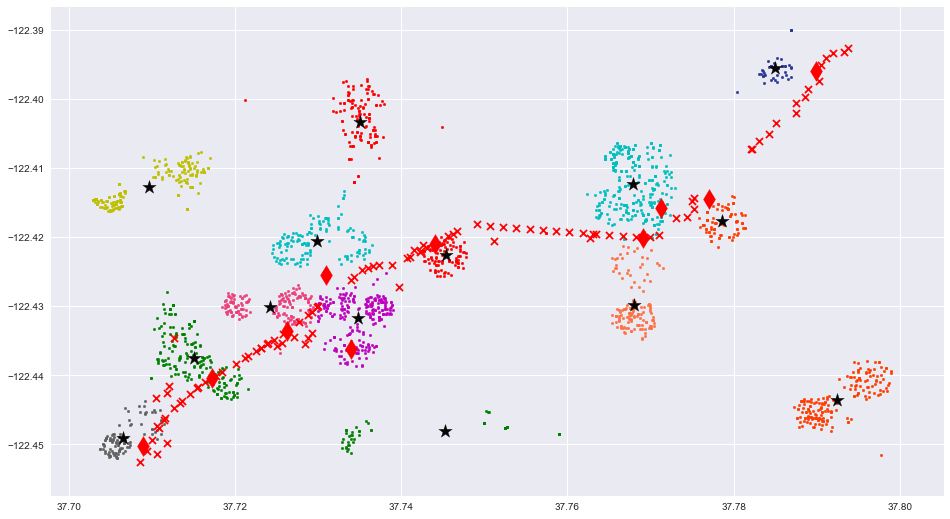

In [174]:
colors = ['#ff3d00', 'g', 'r', 'c', 'm', 'y', '#ff7043', '#616161','#ec407a','#283593']
fig, ax = plt.subplots()
for k in range(len(centroids)):
    points = np.array([pointSet[j] for j in np.array([i for i, x in enumerate(kmeans.labels_) if x == k])])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[k%10])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='#050505')
ax.scatter(resultBus[:,0],resultBus[:,1], marker="d"	 , s=200, c='r')
ax.scatter(latsBus,lonsBus, marker="x"	 , s=50, c='r')